# Plot of Sagnac Drift of Rings

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory


In [2]:
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan
from functions.get_mlti_statistics import __get_mlti_statistics
from functions.get_lxx_intervals import __get_lxx_intervals
from functions.load_lxx import __load_lxx


In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [4]:
config = {}

# specify length of time interval to show
config['time_interval'] = 10 # days

# define time interval
config['tend'] = UTCDateTime().now()
config['tbeg'] = config['tend'] - config['time_interval'] * 86400

Zlower, Zupper = 553.55, 553.60
Ulower, Uupper = 302.39, 302.49
Vlower, Vupper = 447.70, 447.75

# specify path to data
config['path_to_sds'] = archive_path+"romy_archive/"

# path to Sagnac beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

# path to figure output
config['path_to_figs'] = root_path+f"Documents/ROMY/HTML_Monitor/figures/"


### Load beat data

In [5]:
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatZ = __load_sagnac_beat_data(config['tbeg'], config['tend'], "Z", config['path_to_autodata'])
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

error for 2024/RU/FJU_20240628.pkl
error for 2024/RZ/FJZ_20240628.pkl
error for 2024/RV/FJV_20240628.pkl


In [6]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    time_scaling = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    try:
        ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj)
        ax[0].set_ylim(553.53, 553.60)
        ax[0].ticklabel_format(useOffset=False)
    except:
        pass
    try:
        ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj)
        ax[1].set_ylim(302.4, 302.5)
        ax[1].ticklabel_format(useOffset=False)
    except:
        pass
    try:
        ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj)
        ax[2].set_ylim(447.6, 447.8)
        ax[2].ticklabel_format(useOffset=False)
    except:
        pass

    # ax[2].axhline(np.nanpercentile(beatV.fj, 99))
    # ax[2].axhline(np.nanpercentile(beatV.fj, 1))

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)


    # ax[0].set_ylim(Zlower, Zupper)
    # ax[1].set_ylim(Ulower, Uupper)
    # ax[2].set_ylim(Vlower, Vupper)

    plt.show();
    return fig

In [7]:
# fig = __makeplot();

### Exclude Outliers

In [8]:
beatZ['fj'] = np.where((beatZ.fj > Zupper), np.nan, beatZ.fj)
beatZ['fj'] = np.where((beatZ.fj < Zlower), np.nan, beatZ.fj)

beatU['fj'] = np.where((beatU.fj > Uupper), np.nan, beatU.fj)
beatU['fj'] = np.where((beatU.fj < Ulower), np.nan, beatU.fj)

beatV['fj'] = np.where((beatV.fj > Vupper), np.nan, beatV.fj)
beatV['fj'] = np.where((beatV.fj < Vlower), np.nan, beatV.fj)

### Load Maintenance LXX log

In [9]:
try:
    # load log file
    lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

    # get intervals of maintenance work as utc times
    lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

except Exception as e:
    print(e)
    print(f" -> failed to load maintenance log")


### Remove MLTI times

In [10]:
try:
    # load mlti log
    mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

    # extract time intervals
    mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

    # set MLTI intervals to NaN
    beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

    # interpolate NaN values
    beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))

except:
    print(f" -> failed to load mlti log for RU")

In [11]:
try:
    # load mlti log
    mltiZ = __load_mlti(config['tbeg'], config['tend'], "Z", archive_path)

    # extract time intervals
    mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

    # set MLTI intervals to NaN
    beatZ = __mlti_intervals_to_NaN(beatZ, "fj", "times_utc", mltiZ_t1, mltiZ_t2, t_offset_sec=180)

    # interpolate NaN values
    beatZ['fj_inter'] = __interpolate_nan(np.array(beatZ.fj_nan))

except:
    print(f" -> failed to load mlti log for RZ")

In [12]:
try:
    # load mlti log
    mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)

    # extract time intervals
    mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)

    # set MLTI intervals to NaN
    beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)

    # interpolate NaN values
    beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))

except:
    print(f" -> failed to load mlti log for RV")

### Get MLTI statistics

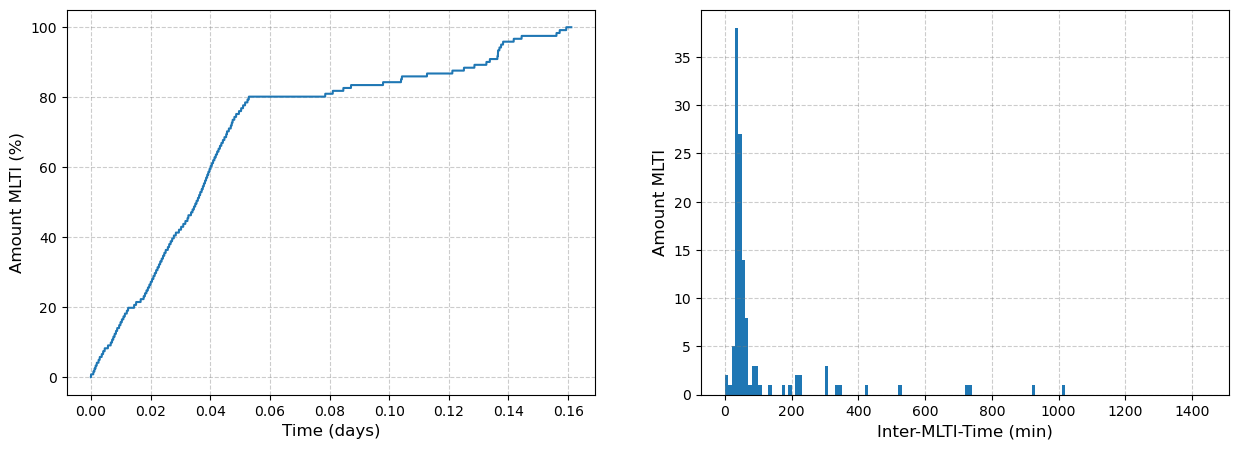

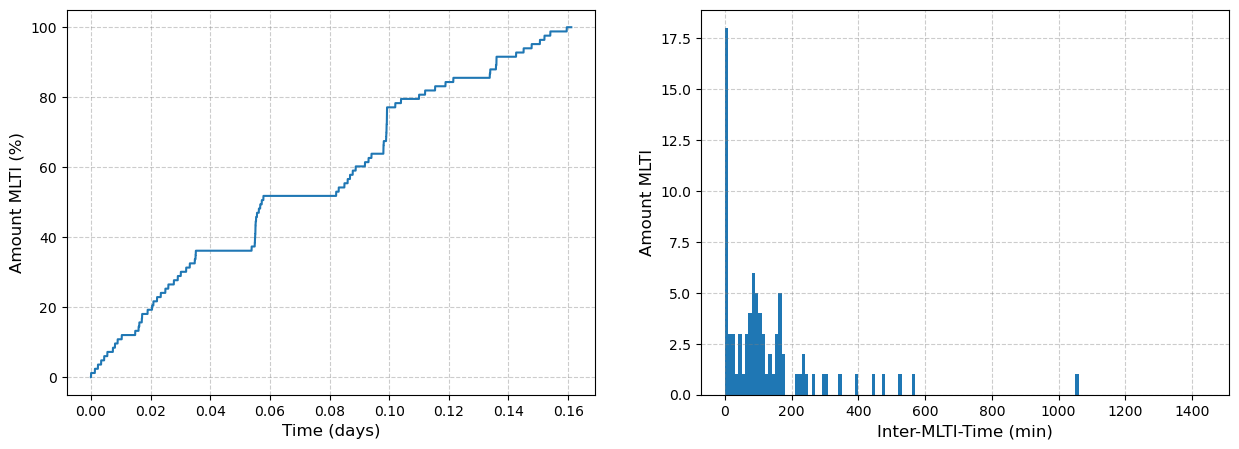

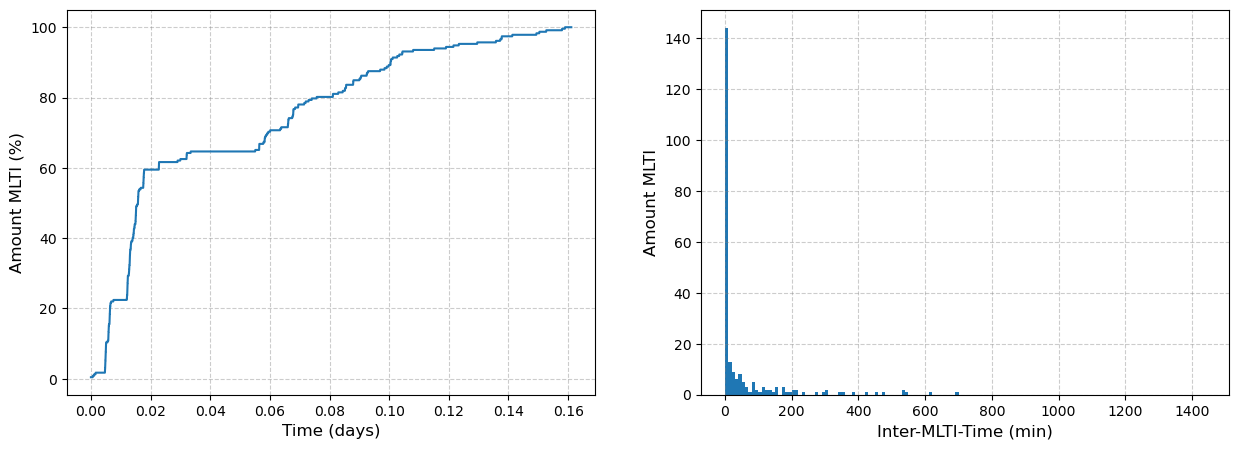

In [13]:
try:
    arr_mltiU, mltiU_cumsum, mlti_cumsum_percent, mltiU_inter_sec = __get_mlti_statistics(mltiU_t1, np.array(beatU.times_utc), plot=True, ylog=False)
except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RU")

try:
    arr_mltiV, mltiV_cumsum, mlti_cumsum_percent, mltiV_inter_sec = __get_mlti_statistics(mltiV_t1, np.array(beatV.times_utc), plot=True, ylog=False)
except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RV")

try:
    arr_mltiZ, mltiZ_cumsum, mlti_cumsum_percent, mltiZ_inter_sec = __get_mlti_statistics(mltiZ_t1, np.array(beatZ.times_utc), plot=True, ylog=False)
except Exception as e:
    print(e)
    print(f" -> failed to get MLTI statistics for RZ")


## Smoothing

In [14]:
n_minutes = 24*60

try:
    beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)

    maskU = np.where(np.isnan(beatU.fj_nan), np.nan, 1)

    beatU['fj_smooth_masked'] = beatU['fj_smooth'] * maskU

except:
    pass

try:
    beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)

    maskV = np.where(np.isnan(beatV.fj_nan), np.nan, 1)

    beatV['fj_smooth_masked'] = beatV['fj_smooth'] * maskV

except:
    pass

try:
    beatZ['fj_smooth'] = __smooth(beatZ.fj_inter, n_minutes)

    maskZ = np.where(np.isnan(beatZ.fj_nan), np.nan, 1)

    beatZ['fj_smooth_masked'] = beatZ['fj_smooth'] * maskZ

except:
    pass


## Plotting

/tmp/ipykernel_441297/3774456047.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


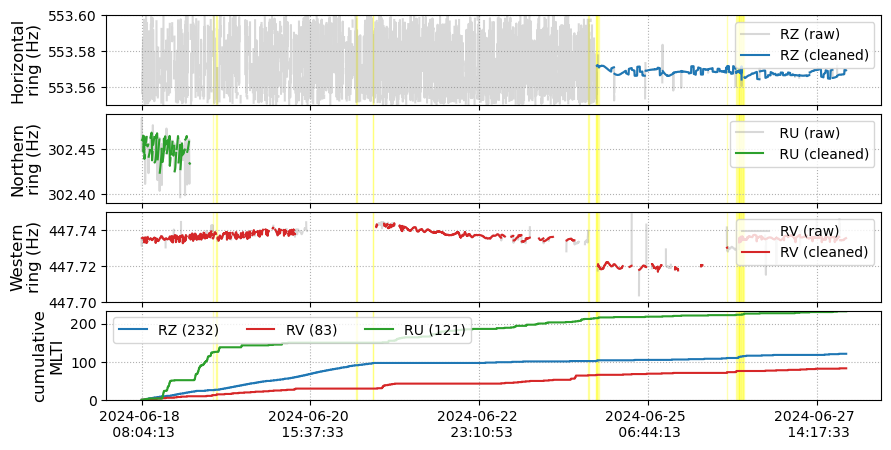

In [15]:
def __makeplot():

    Nrow, Ncol = 4, 1

    font = 12

    # ref_date = UTCDateTime(str(beatV.times_utc.iloc[0])[:10])
    ref_date = config['tbeg']

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(10, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    # time_scaling = 1/86400
    time_scaling = 1

    try:
        ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="RZ (raw)")
        ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_nan, color="tab:blue", label="RZ (cleaned)")
        # ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    except:
        pass
    ax[0].set_ylim(Zlower, Zupper)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal\nring (Hz)", fontsize=font)

    try:
        ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label=" RU (raw)")
        ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_nan, color="tab:green", label=" RU (cleaned)")
        # ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    except:
        pass
    ax[1].set_ylim(Ulower, Uupper)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern\nring (Hz)", fontsize=font)

    try:
        ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="RV (raw)")
        ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_nan, color="tab:red", label="RV (cleaned)")
        # ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth_masked, color="k", label=f"mov. avg. ({n_minutes} min)")
    except:
        pass
    ax[2].set_ylim(Vlower, Vupper)
    ax[2].set_ylim()
    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western\nring (Hz)", fontsize=font)

    max_mlti = max([max(mltiZ_cumsum), max(mltiU_cumsum), max(mltiV_cumsum)])

    try:
        ax[3].plot(beatU.times_utc_sec*time_scaling, mltiU_cumsum, color="tab:blue", label=f"RZ ({int(mltiZ_cumsum[-1])})")
    except:
        pass
    try:
        ax[3].plot(beatV.times_utc_sec*time_scaling, mltiV_cumsum, color="tab:red", label=f"RV ({int(mltiV_cumsum[-1])})")
    except:
        pass
    try:
        ax[3].plot(beatZ.times_utc_sec*time_scaling, mltiZ_cumsum, color="tab:green", label=f"RU ({int(mltiU_cumsum[-1])})")
    except:
        pass

    ax[3].set_ylim(0, max_mlti+2)
    ax[3].set_ylabel("cumulative\nMLTI", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1, ncol=1)

        # add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    ax[3].legend(loc=2, ncol=3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    # add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(config['tbeg']+t).date} \n {str(UTCDateTime(config['tbeg']+t).time).split('.')[0]}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)


    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"html2_beatdrift.png", format="png", dpi=150, bbox_inches='tight')


In [16]:
# plt.plot(__smooth(arr_mltiZ, 60))